In [47]:
import qutip.core.gates
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")

In [111]:
def prep_aux_gad(k, current_position):
    aux_H = 0.5 * (tensor([0.5 * (I - (Z if j  == i else I)) for i in range(k)]))
    
    # Embed aux_H into the full space
    pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
    post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block    
    full_aux_H = tensor(pre_space + [aux_H] + post_space)


    ####### FOR PRINTING Aux #######
    to_p = (
        pre_space
        + [0.5 * (I - (Z if j  == i else I)) for i in range(k)]
        + post_space
    )
    print_gadget(to_p)
    ####### FOR PRINTING Aux #######


    return full_aux_H


def prep_aux_gad_jordan(k, i, current_position):
    # Construct the ancillary Hamiltonian
    anc_accum = 0
    for j in range(i + 1, k):
        # Construct the pairwise interaction term for the ancillary space
        aux = [0.5*(I - (Z if idx == i or idx == j else I)) for idx in range(k)]
        aux_H = tensor(aux)
        
    
        # Embed aux_H into the full space
        pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
        post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
        full_aux_H = tensor(pre_space + [aux_H] + post_space)
        
        anc_accum += full_aux_H
        ###### FOR PRINTING Aux #######
        to_p = (pre_space + aux + post_space)
        print_gadget(to_p)
        ###### FOR PRINTING Aux #######
        
    return anc_accum


def prep_v_gad(k, j, aux_count_v, current_position):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    
    # auxiliary_operator = tensor([X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)])
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    # Embed auxiliary operator into the full auxiliary space
    pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
    post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
    full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
    
    # Combine logical and full auxiliary operators
    full_v = tensor(logical_operator, full_auxiliary_operator)            

    ####### FOR PRINTING V #######
    # to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)] + post_aux
    to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + aux + post_aux
    print_gadget(to_p)
    ####### FOR PRINTING V #######
    
    return full_v

In [177]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define stabilizer generators for the 4-qubit code
four_local = [X, X, Y, Z]
# t = [X, X, Y, X]
# a_four_local = [X, I, Y, I]

# hs = [four_local, t, a_four_local]
hs = [four_local]

# Parameters
total_logic_qbits = 4  # Number of logical qubits

ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
tot_space = total_logic_qbits + sum(ks)

# Initialize the total Hamiltonian
# H_gad = tensor([Qobj(np.zeros((2, 2))) for _ in range(tot_space)])  # Start with a zero operator
H_gad = 0

perturbation_factor = 1

# Build auxiliary Hamiltonians and embed them
current_position = total_logic_qbits  # Start after logical qubits
for index, operator in enumerate(hs):
    k = sum(1 for op in operator if op != I)    
    print(k)
    
    for j in range(k):
        full_aux_H = prep_aux_gad_jordan(k, j, current_position)
        H_gad += full_aux_H
        
    # Now adding the perturbative terms
    aux_count_v = 0
    for j, op in enumerate(operator):
        if op == I:
            continue     
        
        full_v = prep_v_gad(k, j, aux_count_v, current_position)
        aux_count_v += 1
        
        H_gad += perturbation_factor*full_v

    current_position += k
    print()

print("Total Hamiltonian Dimensions:", H_gad.dims)

4
tensor(I, I, I, I, 1/2(I-Z), 1/2(I-Z), I, I)
tensor(I, I, I, I, 1/2(I-Z), I, 1/2(I-Z), I)
tensor(I, I, I, I, 1/2(I-Z), I, I, 1/2(I-Z))
tensor(I, I, I, I, I, 1/2(I-Z), 1/2(I-Z), I)
tensor(I, I, I, I, I, 1/2(I-Z), I, 1/2(I-Z))
tensor(I, I, I, I, I, I, 1/2(I-Z), 1/2(I-Z))
tensor(X, I, I, I, X, I, I, I)
tensor(I, X, I, I, I, X, I, I)
tensor(I, I, Y, I, I, I, X, I)
tensor(I, I, I, Z, I, I, I, X)

Total Hamiltonian Dimensions: [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]]


In [180]:
Had = qutip.core.gates.hadamard_transform(1)

Had_four = tensor(Had, Had, Had, Had, I, I, I, I)
basis_states = [basis(2, 0), basis(2, 1)]

zero_state = tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0])
plus_state = Had_four * zero_state

print("Plus Hamiltonian Dimensions:", plus_state.dims)

Plus Hamiltonian Dimensions: [[2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1]]


[[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]]
{np.float64(-4.0): 16, np.float64(-2.0): 64, np.float64(-0.0): 96, np.float64(2.0): 64, np.float64(4.0): 16}


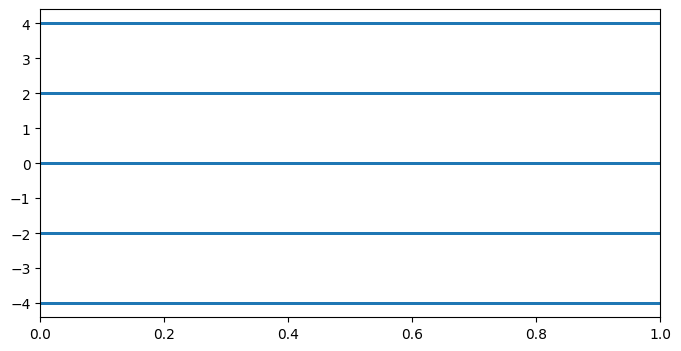

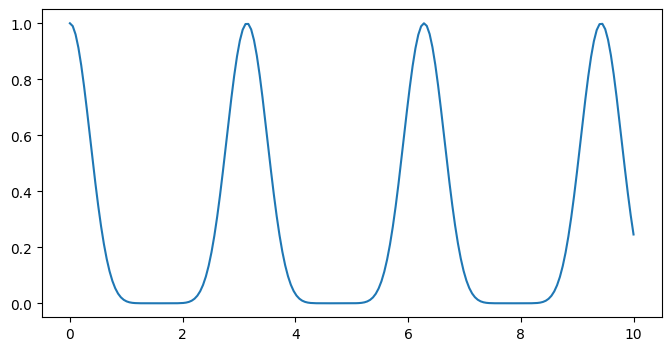

In [181]:
eigenvalues, eigenstates = H_gad.eigenstates()
energies = {}

print(H_gad.dims)
plt.figure(figsize=(8, 4))
# Loop through both arrays
for energy, state in zip(eigenvalues, eigenstates):
    energy = np.round(energy, 10)
    
    if energy not in energies.keys():
        energies[energy] = 1
    else:
        energies[energy] += 1    
    plt.axhline(y = energy, linestyle = '-', linewidth = 2)

print(energies)

P_plus = plus_state * plus_state.dag()
P_zero = zero_state * zero_state.dag()
times = np.linspace(0, 10, 200)

evolution = sesolve(H_gad, plus_state, times, e_ops=[P_plus])

plt.figure(figsize=(8, 4))
plt.plot(times, evolution.expect[0], label=r"")


In [182]:
Had = qutip.core.gates.hadamard_transform(1)

Had_four = tensor(Had, Had, Had, Had)
basis_states = [basis(2, 0), basis(2, 1)]

zero_state = tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0])
plus_state = Had_four * zero_state

print("Plus Hamiltonian Dimensions:", plus_state.dims)

Plus Hamiltonian Dimensions: [[2, 2, 2, 2], [1, 1, 1, 1]]


[[2, 2, 2, 2], [2, 2, 2, 2]]
{np.float64(-1.0): 8, np.float64(1.0): 8}


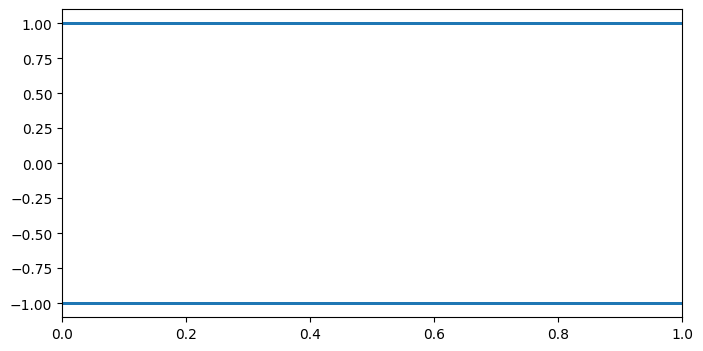

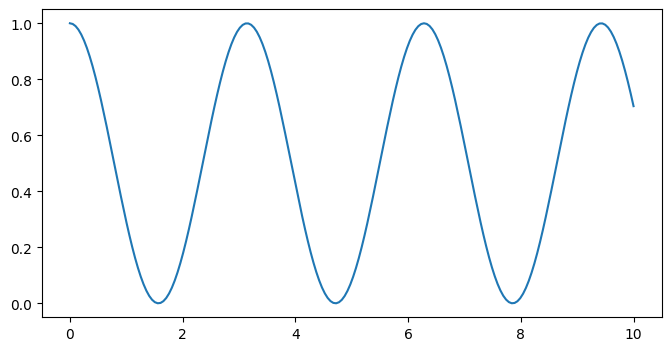

In [183]:
eigenvalues, eigenstates = tensor(four_local).eigenstates()
energies = {}

print(tensor(four_local).dims)
plt.figure(figsize=(8, 4))
# Loop through both arrays
for energy, state in zip(eigenvalues, eigenstates):
    energy = np.round(energy, 10)
    
    if energy not in energies.keys():
        energies[energy] = 1
    else:
        energies[energy] += 1    
    plt.axhline(y = energy, linestyle = '-', linewidth = 2)

print(energies)

P_plus = plus_state * plus_state.dag()
P_zero = zero_state * zero_state.dag()

times = np.linspace(0, 10, 200)

H = tensor(four_local)
evolution = sesolve(H, plus_state, times, e_ops=[P_plus])

plt.figure(figsize=(8, 4))
plt.plot(times, evolution.expect[0], label=r"")